# Language Modelling Interpretability

## How Does ChatGPT Predict the Next Word?

Have you ever wondered how AI chatbots like ChatGPT know what word to say next? At its core, every language model is playing a prediction game: given some text, what character (or word) should come next?

In this lab, you'll build and train your own language models from scratch, starting with the simplest possible version and working up to the same attention mechanism that powers ChatGPT.

### What You'll Learn

1. **Train a Bigram Model** - A model that predicts the next character based *only* on the current character. It's just a 65×65 table of probabilities!

2. **Look Inside the Model's Brain** - Unlike massive AI models with billions of parameters, our simple models are fully interpretable. You'll visualize exactly what the model learned.

3. **Experiment with Embeddings** - See how AI represents characters as vectors (lists of numbers) and discover which characters the model thinks are "similar."

4. **Understand Self-Attention** - Learn the key innovation that makes modern AI so powerful: the ability to "pay attention" to relevant context.

### Why Shakespeare?

We'll train on Shakespeare's plays because the text is:
- Free and publicly available
- Has interesting patterns (character names, dramatic speech, old English)
- Small enough to train quickly on any computer

**Let's see what a neural network can learn about language!**

This is inspired by the follwing [video](https://www.youtube.com/watch?v=kCc8FmEb1nY) by Andrej Karpathy that goes much more in-depth!

Run the following setup code to start the investigation

In [2]:
import torch
from bigram_model import (
    setup_bigram_model,
    train_model,
    BigramLanguageModel,
    EmbeddingLanguageModel,
    SingleHeadAttentionModel,
    generate_with_temperature,
    sequence_probability,
    print_sequence_analysis,
    save_weights_snapshot
)
from visualization import (
    plot_training_history,
    visualize_learned_vs_actual,
    visualize_top_predictions,
    compare_embeddings_before_after,
    plot_token_embedding_pca,
    plot_token_embedding_similarity,
    find_similar_characters,
    show_attention,
    explore_capitalization_direction,
    plot_capitalization_similarity
)

In [3]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open("input.txt", "r", encoding="utf-8") as f:
    text = f.read()

--2026-01-17 18:50:15--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: 'input.txt.4'

     0K .......... .......... .......... .......... ..........  4% 1.79M 1s
    50K .......... .......... .......... .......... ..........  9% 2.99M 0s
   100K .......... .......... .......... .......... .......... 13% 5.12M 0s
   150K .......... .......... .......... .......... .......... 18% 18.0M 0s
   200K .......... .......... .......... .......... .......... 22% 3.68M 0s
   250K .......... .......... .......... .......... .......... 27% 69.6M 0s
   300K .......... .......... .......... .......... .......... 32%  107M 0s
   350K .......... 


## 1. Training a Simple Bigram Model

### 1.1 How Do We Turn Text Into Numbers?

Neural networks only understand numbers, not letters. So before we can train a model, we need to convert text into a sequence of numbers. This process is called **tokenization** and **encoding**.

### The Big Picture

```
"Hello" → ['H', 'e', 'l', 'l', 'o'] → [20, 43, 50, 50, 53]
  text        characters (tokens)         numbers (indices)
```

### Why Is This Necessary?

Deep learning models are fundamentally mathematical machines. They multiply matrices, compute gradients, and optimize loss functions - all operations that require numerical inputs. When you type "Hello" to ChatGPT, it doesn't see letters; it sees a sequence of numbers that it can process mathematically.

### Key Terminology

- **Token**: The smallest unit of text we work with. In our case, a single character. (GPT models use "subword" tokens that are pieces of words, like "un", "happi", "ness")

- **Vocabulary**: The complete set of unique tokens our model knows about. Our Shakespeare dataset has 65 unique characters (letters, numbers, punctuation, spaces, newlines).

- **Encoding**: Converting tokens → numbers using a lookup table

- **Decoding**: Converting numbers → tokens (the reverse process)


Let's build this step by step!

In [4]:
# Step 1: Find all unique characters in our text
# set(text) gives us unique characters, sorted() puts them in order
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f"Our vocabulary has {vocab_size} unique characters:")
print(chars)
print(f"\nThis includes letters, numbers, punctuation, spaces, and newlines!")

Our vocabulary has 65 unique characters:
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

This includes letters, numbers, punctuation, spaces, and newlines!


In [5]:
# Step 2: Create lookup tables (dictionaries)
# stoi = "string to integer" - converts a character to its index
# itos = "integer to string" - converts an index back to a character

stoi = {ch: i for i, ch in enumerate(chars)}  # {'a': 0, 'b': 1, ...}
itos = {i: ch for i, ch in enumerate(chars)}  # {0: 'a', 1: 'b', ...}

# Let's see some examples
print("Character → Number (stoi):")
for char in ['a', 'e', 'z', ' ', '\n']:
    print(f"  '{char}' → {stoi[char]}")

print("\nNumber → Character (itos):")
for idx in [0, 10, 20, 30, 40]:
    print(f"  {idx} → '{itos[idx]}'")

Character → Number (stoi):
  'a' → 39
  'e' → 43
  'z' → 64
  ' ' → 1
  '
' → 0

Number → Character (itos):
  0 → '
'
  10 → ':'
  20 → 'H'
  30 → 'R'
  40 → 'b'


### 1.2 The Bigram Model

#### What is a Bigram?

A **bigram** is simply a pair of consecutive characters (or words). The word comes from "bi" (two) + "gram" (unit). For example, in the word "hello":
- Bigrams: `he`, `el`, `ll`, `lo`

A **bigram model** predicts the next character based *only* on the current character - it has no memory of anything before that!

#### How Does It Work?

The model learns a **probability table**: "Given that I just saw character X, what's the probability of each possible next character?"

```
Current char → Next char probabilities
     'q'     → 'u': 95%, 'a': 2%, 'e': 1%, ...
     't'     → 'h': 30%, 'o': 15%, 'e': 12%, ...
     ' '     → 't': 8%, 'a': 7%, 's': 6%, ...
```

### The Math: A Simple Lookup Table

Our bigram model is literally a **65×65 table** (one row per character, one column per possible next character):

$$
W = \begin{pmatrix}
 & a & b & c & d & e & \cdots \\
a & 0.10 & 0.02 & 0.05 & 0.03 & 0.01 & \cdots \\
b & 0.20 & 0.01 & 0.03 & 0.02 & 0.15 & \cdots \\
c & 0.15 & 0.01 & 0.02 & 0.01 & 0.08 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
\in \mathbb{R}^{65 \times 65}
$$

Each row sums to 1.0 (it's a probability distribution). The model has **65 × 65 = 4,225 learnable parameters**.

### Why Is This "Neural"?

In PyTorch, this table is implemented as an **embedding layer**:
- Input: current character index (0-64)
- Output: a vector of 65 numbers (logits for each next character)
- These logits are converted to probabilities using **softmax**

The "learning" is just adjusting these 4,225 numbers to match the patterns in Shakespeare!

### The Critical Limitation

The bigram model has **no context beyond the current character**. It can't distinguish between:
- "the" → next char after 'e' in "the"
- "she" → next char after 'e' in "she"  

Both just see 'e' and make the same prediction! This is why bigram models generate gibberish - they can't capture longer patterns like words or grammar.

### Why Start Here?

Despite its limitations, the bigram model is perfect for learning because:
1. **Fully interpretable**: We can visualize the entire model as a heatmap
2. **Fast to train**: Only 4,225 parameters
3. **Foundation**: The same training loop works for GPT-scale models
4. **Baseline**: Shows what you *can't* do without attention/context

In [6]:
#run this cell to setup the model!
components = setup_bigram_model("input.txt", seed=1337)

text = components['text']
chars = components['chars']
vocab_size = components['vocab_size']
stoi = components['stoi']
itos = components['itos']
encode = components['encode']
decode = components['decode']
train_data = components['train_data']
val_data = components['val_data']
model = components['model']

# Save weights BEFORE training
weights_before = save_weights_snapshot(model)

print(f"Vocabulary: {vocab_size} characters")
print(f"Model has {vocab_size * vocab_size:,} learnable parameters (a {vocab_size}x{vocab_size} table)")

Vocabulary: 65 characters
Model has 4,225 learnable parameters (a 65x65 table)


### 1.3 Training

**Experiment**: Try different hyperparameters and see how they affect learning.

In [7]:
#how much data we train on in each step
batch_size = 32         # Try: 16, 32, 64, 128

#how many steps we train for
max_iters = 10000       # Try: 1000, 5000, 10000

#how much we update the model every step
learning_rate = 1e-3    # Try: 1e-2, 1e-3, 1e-4

history = train_model(
    model, train_data, val_data,
    batch_size=batch_size,
    max_iters=max_iters,
    eval_interval=1000,
    lr=learning_rate
)

Step 0: Train Loss: 4.7296, Val Loss: 4.7229
Step 1000: Train Loss: 3.7320, Val Loss: 3.7312
Step 2000: Train Loss: 3.1288, Val Loss: 3.1292
Step 3000: Train Loss: 2.7997, Val Loss: 2.8051
Step 4000: Train Loss: 2.6383, Val Loss: 2.6451
Step 5000: Train Loss: 2.5597, Val Loss: 2.5700
Step 6000: Train Loss: 2.5140, Val Loss: 2.5367
Step 7000: Train Loss: 2.4998, Val Loss: 2.5145
Step 8000: Train Loss: 2.4786, Val Loss: 2.4961
Step 9000: Train Loss: 2.4768, Val Loss: 2.4963


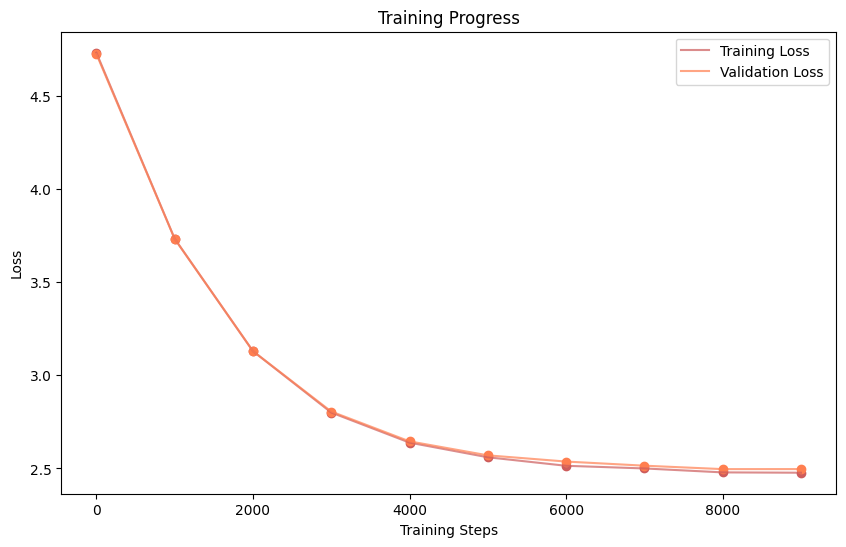

In [8]:
plot_training_history(history, eval_interval=1000)

### 1.4 What Did Training Change?

Compare the embedding table before and after training. The model started with random weights and learned to approximate the true bigram distribution from Shakespeare.

#### How to Read These Heatmaps

Each heatmap shows the **65×65 probability table** we discussed earlier:
- **Y-axis (rows)**: The "current character" - the character we just saw
- **X-axis (columns)**: The "next character" - what the model predicts comes next
- **Color intensity**: The probability of that transition (brighter = higher probability)

To find a specific probability, locate the current character on the y-axis and the next character on the x-axis. For example, to find $P(\text{'u'} \mid \text{'q'})$:
1. Find 'q' on the y-axis (current character)
2. Find 'u' on the x-axis (next character)
3. The color at that intersection shows the probability

#### What to Look For

**Before Training (Left):**
- The probabilities are roughly uniform (random noise)
- Every character has about equal chance of following any other character
- This is because the weights were randomly initialized using a normal distribution

**After Training (Middle):**
- Clear patterns emerge! You'll see bright spots and dark regions
- Look for the row corresponding to 'q' - it should have a bright spot at 'u'
- The space character row should show high probability for common word-starting letters
- Vowels tend to be followed by consonants and vice versa

**Change Map (Right):**
- **Red cells**: Probability *increased* during training (the model learned this transition is common)
- **Blue cells**: Probability *decreased* during training (the model learned this transition is rare)
- **White cells**: Little change (either already correct or genuinely uncertain)

#### The Math Behind the Change

The change map shows:

$$
\Delta P(b \mid a) = P_{\text{after}}(b \mid a) - P_{\text{before}}(b \mid a)
$$

Large positive values (red) mean the model significantly increased its confidence in that transition. Large negative values (blue) mean it learned to avoid that transition.

#### Key Insight

The model has essentially "memorized" which character pairs appear frequently in Shakespeare. This is both its strength (accurate bigram statistics) and its weakness (no understanding beyond pairs).

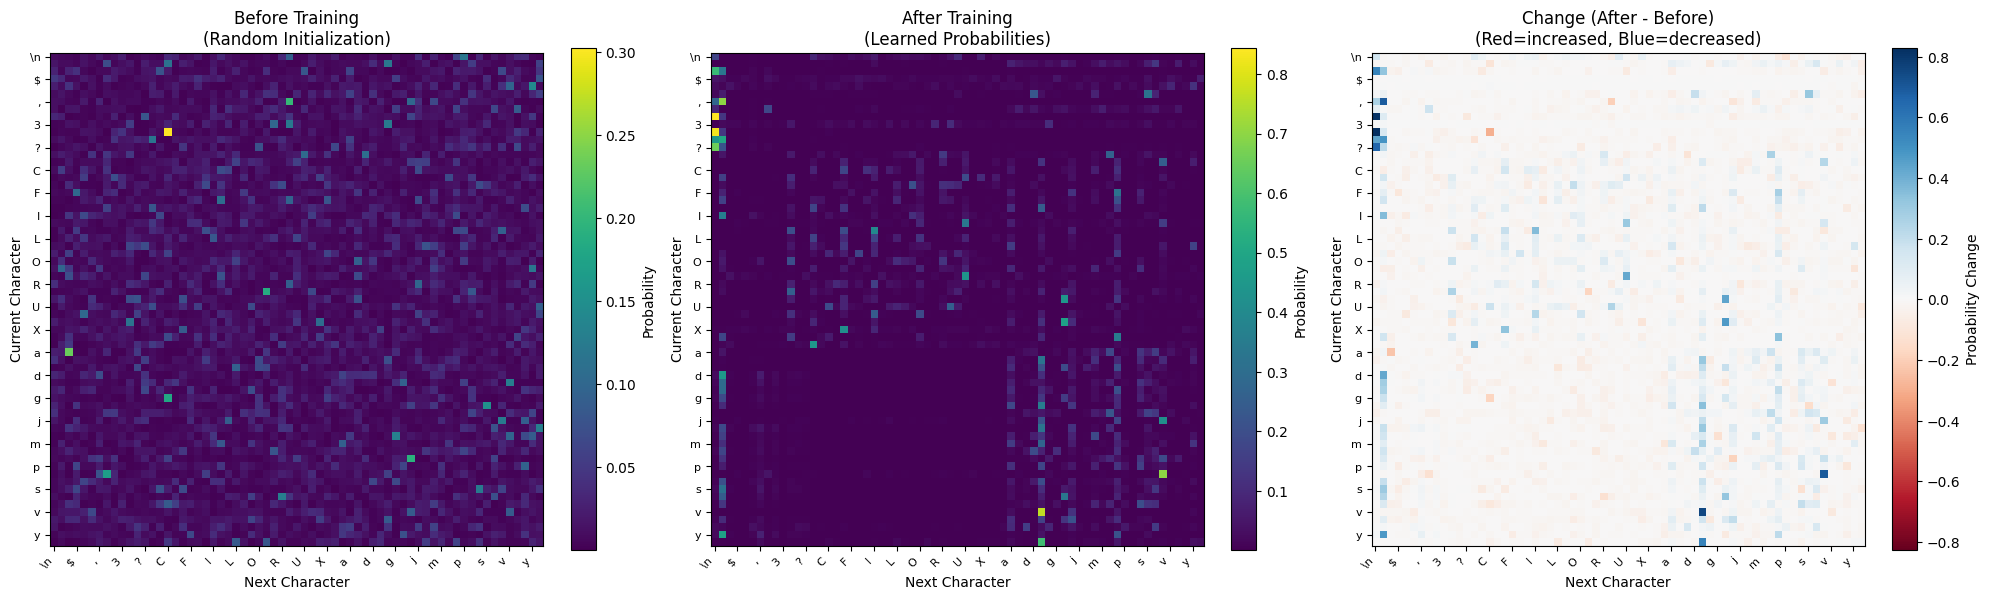

Total weight change (L2 norm): 233.1700


In [9]:
#run this cell
compare_embeddings_before_after(weights_before, model, chars)

### 1.5 Learned vs Actual: How Well Did It Learn?

The model should learn the **true bigram frequencies** from Shakespeare. But what are the "true" frequencies, and how do we calculate them?

#### Calculating True Bigram Frequencies

To find the actual probability of character $b$ following character $a$ in the text, we:

1. **Count all bigrams**: Scan through the text and count every occurrence of each character pair

$$
\text{count}(a \to b) = \text{number of times } b \text{ follows } a \text{ in the corpus}
$$

2. **Normalize by row**: Divide each count by the total times we saw the first character

$$
P(b \mid a) = \frac{\text{count}(a \to b)}{\sum_{c} \text{count}(a \to c)}
$$

#### Example Calculation

Suppose in our text we see:
- 'th' appears 5,000 times
- 'te' appears 1,000 times  
- 'ta' appears 500 times
- 't' followed by anything: 10,000 times total

Then:
$$
P(\text{'h'} \mid \text{'t'}) = \frac{5000}{10000} = 0.50
$$

The model should learn that after 't', there's a 50% chance of 'h'!

#### What the Visualization Shows

- **Left (Actual Frequencies)**: The "ground truth" - computed directly by counting bigrams in Shakespeare
- **Middle (Learned Probabilities)**: What our neural network learned after training
- **Right (Absolute Difference)**: How far off the model is (darker = bigger error)

#### What to Look For

If training worked well:
- The left and middle plots should look nearly identical
- The difference plot should be mostly dark (small errors)
- Bright spots in the difference plot reveal where the model struggles

**Key insight**: The bigram model can perfectly learn these statistics given enough training - it has exactly the right capacity (65×65 parameters for 65×65 probabilities)!

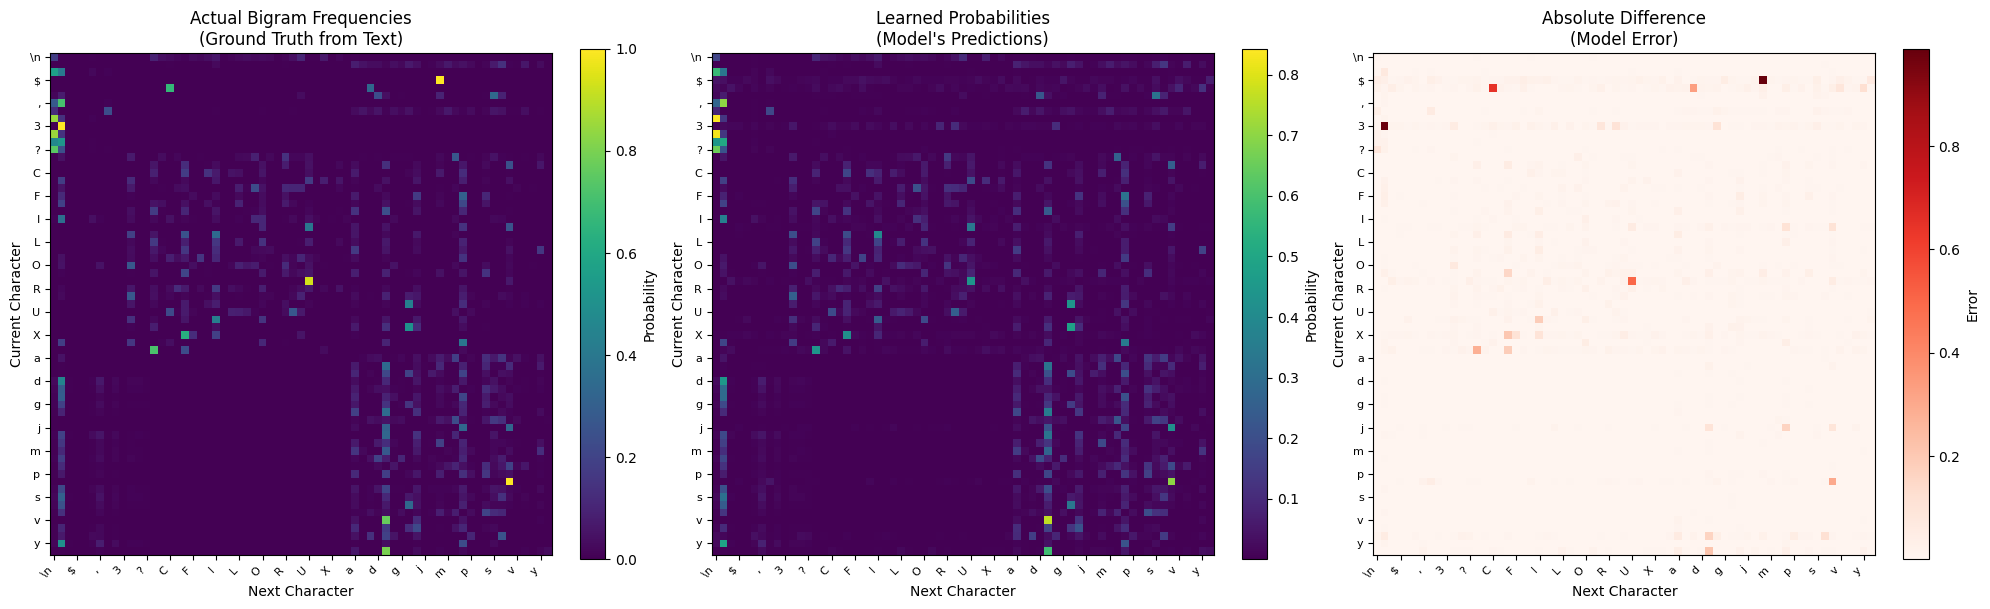

Mean absolute error: 0.004604
Max absolute error: 0.988361


In [10]:
#run this cell
visualize_learned_vs_actual(model, text, stoi, vocab_size, chars)

### 1.6 Probe the Model: What Does It Predict?

Another way of interpreting the model could be to extract what charecters the model would predict after a given charecter and whether this matches up with our intuitions.

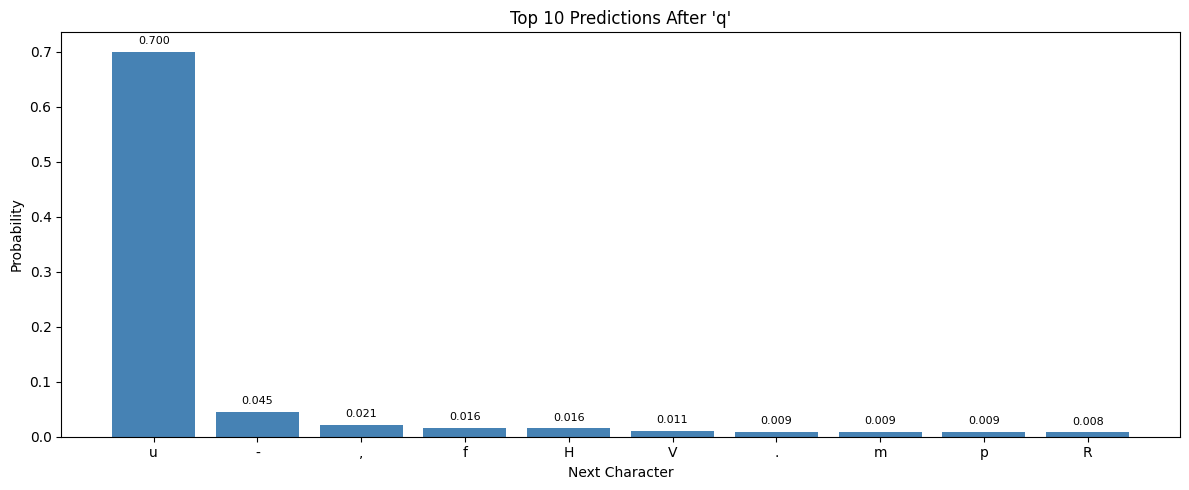

In [11]:
# =============================================
# TRY DIFFERENT CHARACTERS!
# =============================================
char_to_probe = 'q'  # Try: 't', 'e', ' ', 'q', 'x'

visualize_top_predictions(model, char_to_probe, stoi, itos, k=10)

**Questions to explore:**
- What does the model predict after 'q'? (Should be 'u')
- What about after 't'? After ' ' (space)?
- Why might some predictions be wrong?

### 1.7 Generating Text

As a last experiment, lets try to generate sequences from the model. We can change a parameter called the "temperature" which controls how random/deterministic our generation is. Try to change the temperature and see how it affects the seqeunces produced

Temperature scales the logits before sampling:
- **Low (0.2-0.5)**: More deterministic, picks high-probability characters
- **High (1.5-2.0)**: More random, explores unlikely characters

In [12]:
#change this:
temp = 1

idx = torch.zeros((1, 1), dtype=torch.long)
output = generate_with_temperature(model, idx, 80, temperature=temp)
print(f"\nTemp={temp}: {decode(output[0].tolist())}")


Temp=1: 
's pe will y bet heldu botwo?
teshacowingig o I ttRiny bjerifr lor niseaseat ss 


### 1.8 Reflection Questions

1. **Why can't the bigram model generate coherent sentences?** (Hint: what context does it use?)

2. **The model is a 65x65 table. What would we need to capture trigrams?** (Hint: think about dimensionality)

3. **Why is interpretability harder for larger models like GPT?**

---
## 2. Embedding Language Model: Can We Do Better?

The bigram model is limited - it only uses a direct lookup table. Let's build a smarter model that introduces key concepts used in ChatGPT!

### The Problem with Bigrams

The bigram model represents each character as just a number (like 'a' = 39). But this tells us nothing about the character itself - is it a vowel? A capital letter? Punctuation?

### The Solution: Represent Characters as Vectors

Instead of a single number, we represent each character as a **list of numbers** (a vector). Think of it like a character's "personality profile":

```
'a' → [0.2, -0.5, 0.8, 0.1, ...]   (32 numbers)
'e' → [0.3, -0.4, 0.7, 0.2, ...]   (similar to 'a' - both vowels!)
'x' → [-0.8, 0.2, -0.3, 0.9, ...]  (very different - rare consonant)
```

This is called a **token embedding**: $E_{\text{token}} \in \mathbb{R}^{65 \times 32}$ (65 characters, each gets a 32-dimensional vector).

### Adding Position Information

The bigram model doesn't know *where* a character appears. But position matters! The letter 't' at the start of a word behaves differently than 't' in the middle.

We add a **positional embedding**: $E_{\text{pos}} \in \mathbb{R}^{8 \times 32}$ (8 positions, each gets a 32-dimensional vector).

### Putting It Together

For each character, we combine "what it is" + "where it is":

$$
\mathbf{h} = \underbrace{E_{\text{token}}[\text{char}]}_{\text{what}} + \underbrace{E_{\text{pos}}[\text{position}]}_{\text{where}}
$$

Then we convert this back to predictions using a **linear projection**:

$$
\text{logits} = \mathbf{h} \cdot W_{\text{lm}}
$$

### The Full Picture

$$
\boxed{\text{character} \xrightarrow{\text{token emb}} \mathbf{e} \xrightarrow{+ \text{pos emb}} \mathbf{h} \xrightarrow{\text{linear}} \text{logits} \xrightarrow{\text{softmax}} \text{probabilities}}
$$

### Why Doesn't This Help Much?

You'll see the embedding model performs similarly to bigram. The reason: **each position still predicts independently**. Position 3 knows it's at position 3, but can't see what's at positions 0, 1, 2!


**The cells below** create the model, train it for 10,000 steps, and compare it to the bigram model.

In [13]:
# =============================================
# EMBEDDING MODEL HYPERPARAMETERS
# =============================================
n_embd = 32          # Embedding dimension (try: 16, 32, 64, 128)
block_size = 8       # Context length

# Create the embedding model
emb_model = EmbeddingLanguageModel(vocab_size, n_embd=n_embd, block_size=block_size)

# Count parameters
bigram_params = sum(p.numel() for p in model.parameters())
emb_params = sum(p.numel() for p in emb_model.parameters())

print(f"Bigram model:   {bigram_params:,} parameters")
print(f"Embedding model: {emb_params:,} parameters")
print(f"\nEmbedding model is {emb_params/bigram_params:.1f}x larger")

Bigram model:   4,225 parameters
Embedding model: 4,481 parameters

Embedding model is 1.1x larger


In [14]:
# Train the embedding model
emb_history = train_model(
    emb_model, train_data, val_data,
    batch_size=32,
    block_size=block_size,
    max_iters=10000,
    eval_interval=1000,
    lr=1e-3
)

Step 0: Train Loss: 4.4786, Val Loss: 4.4704
Step 1000: Train Loss: 2.5993, Val Loss: 2.5960
Step 2000: Train Loss: 2.5252, Val Loss: 2.5357
Step 3000: Train Loss: 2.4917, Val Loss: 2.5134
Step 4000: Train Loss: 2.4872, Val Loss: 2.4993
Step 5000: Train Loss: 2.4753, Val Loss: 2.4866
Step 6000: Train Loss: 2.4704, Val Loss: 2.4920
Step 7000: Train Loss: 2.4698, Val Loss: 2.4880
Step 8000: Train Loss: 2.4765, Val Loss: 2.5046
Step 9000: Train Loss: 2.4727, Val Loss: 2.4885


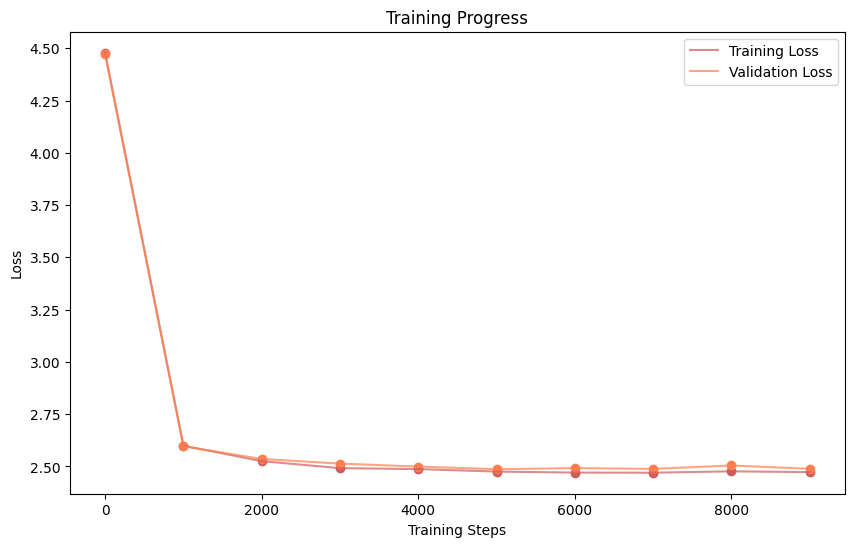

In [15]:
plot_training_history(emb_history, eval_interval=1000)

In [16]:
# Compare final losses
bigram_final = history[-1]['val']
emb_final = emb_history[-1]['val']

print(f"Final Validation Loss:")
print(f"  Bigram model:    {bigram_final:.4f}")
print(f"  Embedding model: {emb_final:.4f}")
print(f"\nImprovement: {bigram_final - emb_final:.4f} ({(bigram_final - emb_final)/bigram_final * 100:.1f}%)")

Final Validation Loss:
  Bigram model:    2.4963
  Embedding model: 2.4885

Improvement: 0.0078 (0.3%)


In [17]:
# Generate text with the embedding model
idx = torch.zeros((1, 1), dtype=torch.long)
emb_output = emb_model.generate(idx, 200)
print("Generated text (Embedding model):")
print("-" * 40)
print(decode(emb_output[0].tolist()))

Generated text (Embedding model):
----------------------------------------



fanathe cat s wne t ce
F it t ofomoyolifthelli' y m w
BRINen sthe at t howis; y beren lan, ser madoughomun be do its gl: ad ge ferersalen to batheroongsuce'dau onuravill, ischaloro, re harenof chitn


---
### 2.1. Interpreting the Embedding Model

The embedding model learned a **32-dimensional vector** for each character. But what do these vectors mean? Let's visualize them!

### Key Concept: Cosine Similarity
Cosine similarity measures how much two vectors "point in the same direction":
- **1.0** = identical direction (very similar)
- **0.0** = perpendicular (unrelated)  
- **-1.0** = opposite directions (very different)

Think of it like comparing arrows: two arrows pointing the same way are similar, regardless of their length.

### 2.1 Token Embeddings: Which Characters Are Similar?

We can compresses the 32-dimensional embeddings down to 2D so we can plot them. Characters that appear **close together** have similar embeddings - the model thinks they behave similarly!

**Questions to explore:**
- Do vowels (a, e, i, o, u) cluster together?
- Are uppercase and lowercase versions of the same letter close?
- Where is the space character? Why might it be in a special location?

Pick a character and find which other characters have the most similar embeddings.

In [18]:
# =============================================
# TRY DIFFERENT CHARACTERS!
# =============================================
char_to_explore = 'e'  # Try: 'a', 't', ' ', 'T', 'q'

similar = find_similar_characters(emb_model, char_to_explore, chars, stoi, top_k=10)

print(f"Characters most similar to '{char_to_explore}':")
print("-" * 30)
for char, sim in similar:
    print(f"  '{repr(char)[1:-1]}': {sim:.3f}")

Characters most similar to 'e':
------------------------------
  'u': 0.590
  'k': 0.332
  ',': 0.259
  'p': 0.237
  'o': 0.226
  'i': 0.223
  'w': 0.191
  'f': 0.179
  'z': 0.176
  't': 0.155


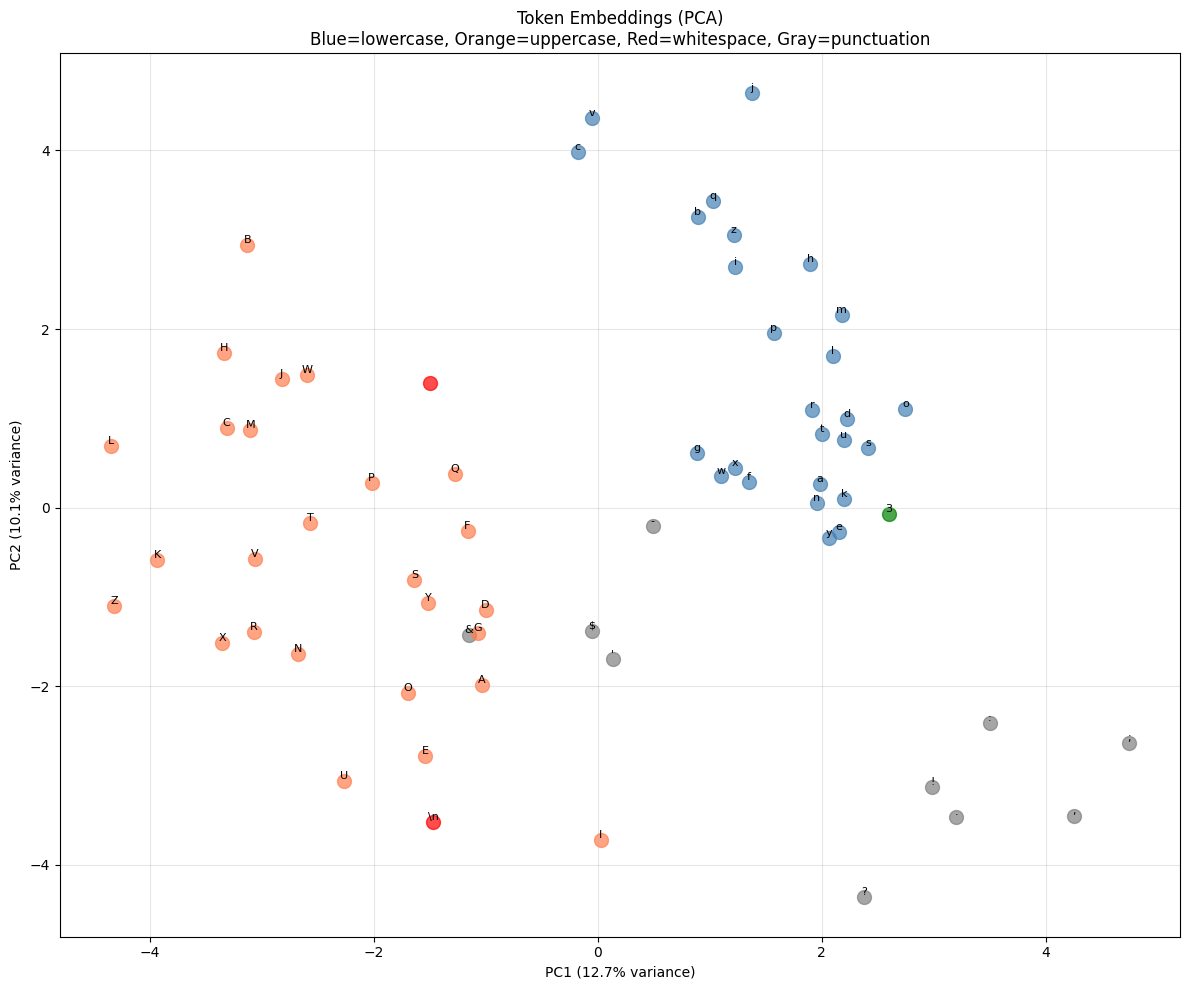

In [19]:
# Visualize character embeddings in 2D
plot_token_embedding_pca(emb_model, chars)

What pattern can you notice about which of the charecters cluster together?

### 2.2 The Linear Representation Hypothesis: Do Embeddings Capture Meaning?

One of the most fascinating discoveries in AI is that **concepts can be represented as directions in embedding space**. This is called the **Linear Representation Hypothesis**.

### The Famous Example: King - Man + Woman = Queen

In word embeddings (like Word2Vec), researchers discovered you could do arithmetic with meanings:

$$
\vec{\text{king}} - \vec{\text{man}} + \vec{\text{woman}} \approx \vec{\text{queen}}
$$

This suggests the model learned a "gender direction" - a consistent way to transform male concepts into female ones!

### Can Our Character Model Do This?

Let's test if our simple character embeddings learned a **"capitalization direction"**:

$$
\vec{\text{A}} - \vec{\text{a}} \approx \vec{\text{B}} - \vec{\text{b}} \approx \vec{\text{C}} - \vec{\text{c}} \approx \cdots
$$

If true, the model discovered that uppercase and lowercase letters differ in a consistent way - even though we never told it about capitalization!

### How to Test This

1. Compute the "capitalization vector" for one letter pair: $\vec{d}_{\text{cap}} = \vec{\text{A}} - \vec{\text{a}}$
2. Apply it to another lowercase letter: $\vec{\text{b}} + \vec{d}_{\text{cap}}$
3. Find which character's embedding is closest to the result
4. If we get 'B', the hypothesis holds!

### Why This Matters

If concepts are directions, then:
- We can **find** what the model knows by searching for directions
- We can **edit** model behavior by adding/subtracting directions
- We can **interpret** what each dimension means

This is a core technique in modern AI interpretability research!

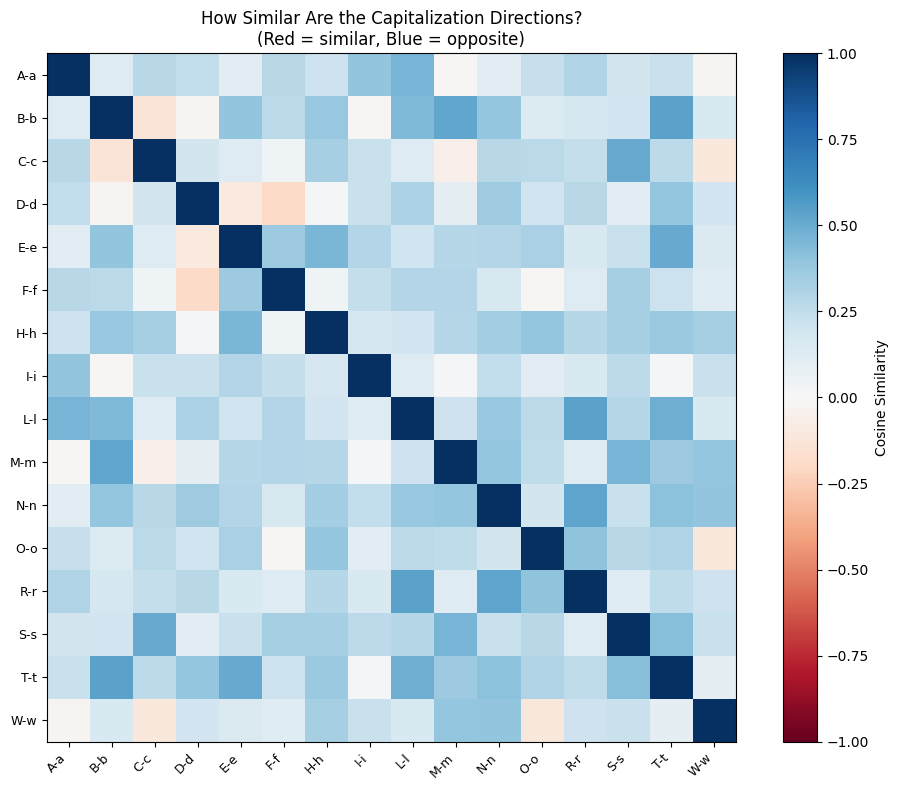


Average similarity: 0.233

Interpretation:
  ~ Mixed colors → The model partially learned capitalization.


In [21]:
# Visualize similarity between all capitalization directions
plot_capitalization_similarity(emb_model, stoi)

### The Bigger Picture

The Linear Representation Hypothesis is a major research area in AI safety and interpretability:

1. **Finding "truth directions"**: Can we find a direction that represents "truthful vs false"?
2. **Editing model behavior**: Add/subtract directions to make models more helpful or less harmful
3. **Understanding what models know**: Probe for directions representing concepts like "Python code" or "formal writing"

**This is how researchers are trying to understand what's happening inside ChatGPT!**

---
## 3. Self-Attention: The Key Innovation in Transformers

The embedding model has a critical limitation: **each position makes its prediction independently**. There's no way for tokens to "communicate" with each other.

### The Problem

Consider predicting the next word in: *"The cat sat on the ___"*

- The word "sat" is very important (tells us we need a location)
- "The" and "cat" are less relevant

A good model should **pay more attention** to "sat" than to "The". But our embedding model treats all positions the same!

### The Solution: Self-Attention

**Self-attention** lets each token look at previous tokens and decide how much to pay attention to each one. The key insight:

> Instead of treating all past tokens equally, let the model **learn** what to pay attention to.

Each token produces:
- **Query (Q)**: "What am I looking for?"
- **Key (K)**: "What do I contain?"
- **Value (V)**: "What information should I provide?"

Attention = how well queries match keys. High match → pay more attention.

**This is why ChatGPT can remember what you said earlier in a conversation!**

Now lets try to train an attention model and see how much it improves the loss!

In [22]:
# =============================================
# ATTENTION MODEL HYPERPARAMETERS
# =============================================
n_embd = 32          # Embedding dimension
block_size = 8       # Context length

# Create the attention model
attn_model = SingleHeadAttentionModel(vocab_size, n_embd=n_embd, block_size=block_size)

# Count parameters
attn_params = sum(p.numel() for p in attn_model.parameters())

print(f"Model Comparison:")
print(f"  Bigram model:     {bigram_params:,} parameters")
print(f"  Embedding model:  {emb_params:,} parameters")
print(f"  Attention model:  {attn_params:,} parameters")

Model Comparison:
  Bigram model:     4,225 parameters
  Embedding model:  4,481 parameters
  Attention model:  7,553 parameters


In [23]:
# Train the attention model
attn_history = train_model(
    attn_model, train_data, val_data,
    batch_size=32,
    block_size=block_size,
    max_iters=10000,
    eval_interval=1000,
    lr=1e-3
)

Step 0: Train Loss: 4.4809, Val Loss: 4.4748
Step 1000: Train Loss: 2.4784, Val Loss: 2.4670
Step 2000: Train Loss: 2.3756, Val Loss: 2.3889
Step 3000: Train Loss: 2.3296, Val Loss: 2.3426
Step 4000: Train Loss: 2.3067, Val Loss: 2.3332
Step 5000: Train Loss: 2.2995, Val Loss: 2.3135
Step 6000: Train Loss: 2.2866, Val Loss: 2.2991
Step 7000: Train Loss: 2.2568, Val Loss: 2.2937
Step 8000: Train Loss: 2.2612, Val Loss: 2.2918
Step 9000: Train Loss: 2.2526, Val Loss: 2.2919


In [26]:
# Compare all three models
print("=" * 50)
print("FINAL VALIDATION LOSS COMPARISON")
print("=" * 50)
print(f"  Bigram model:     {bigram_final:.4f}")
print(f"  Embedding model:  {emb_final:.4f}")
print(f"  Attention model:  {attn_history[-1]['val']:.4f}")

FINAL VALIDATION LOSS COMPARISON
  Bigram model:     2.4963
  Embedding model:  2.4885
  Attention model:  2.2919


### 3.1 Visualizing Attention: What Is the Model Looking At?

The attention heatmap below shows **which characters each position "pays attention to"** when making its prediction.

### How to Read the Attention Heatmap

- **Y-axis (rows)**: The position that is "attending" (making a prediction)
- **X-axis (columns)**: The positions it can look at (attend to)
- **Color intensity**: How much attention (weight) is given (darker/brighter = more attention)
- **Lower triangle only**: Each position can only see itself and previous positions (causal masking) - this prevents "cheating" by looking at future characters

### What the Attention Weights Mean

For a row at position $t$, the values show:

$$
\text{Attention}_t = \text{softmax}\left(\frac{Q_t \cdot K_{0:t}^T}{\sqrt{d}}\right)
$$

Each row sums to 1.0 - it's a probability distribution over which previous positions to focus on.

### What to Look For

- **Diagonal dominance**: If the diagonal is brightest, the model mostly looks at the current character (similar to bigram!)
- **Uniform rows**: If attention is spread evenly, the model averages all previous context equally
- **Specific patterns**: Maybe the model learned to look at the character 2 steps back, or to focus on spaces

### Example Interpretation

For the text "the king":
- When predicting after 'k', does the model look back at the space? At 't'? At 'h'?
- When predicting after 'g', which characters get the most attention?

This is the method that a lot of fronteir research tries to scale up in order to visualize whats going on under the hood of LLMs!

Try different input strings to see how the attention pattern changes!


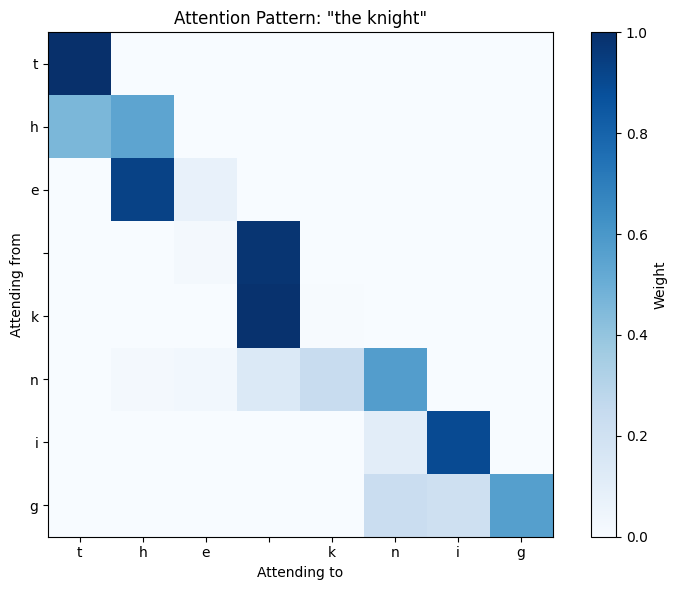

In [ ]:
# Visualize what the attention head learned
show_attention(attn_model, "the knight", encode, decode)